# Predicting a movie rating 
## About the problem
Everyone prefers to know how good is going to be the investment we're about to make. The movies belongs to the group of areas which investing is very expensive so no one wants to waste their money. 


We're going to use IMDB datasets to extract the information to let our model learn. IMDB is one of the greatest web-pages that people often check out to decide if it's worth seeing a movie or not.


How are we going to predict how good a movie is going to be?
Let's start listing our variables and selecting which ones we're going to use..

### Importing required libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib  
import keras
import h5py
import PIL
%matplotlib inline

### Loading dataframes

In [6]:
ds_title_principals = pd.read_csv('dataset_imdb/title.principals.tsv', sep='\t') 
ds_title_ratings = pd.read_csv('dataset_imdb/title.ratings.tsv', sep='\t')
ds_title_basics = pd.read_csv('dataset_imdb/title.basics.tsv', sep='\t')

/home/nachofranco14/Documents/facultad/machine_learning/ds/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Removing innecesary info

We are considering only the titles that have more than 500 votes and the unique type of title is going to be 'movie'

In [7]:
ds_title_ratings = ds_title_ratings[(ds_title_ratings['numVotes'] > 500)]
ds_title_basics['runtimeMinutes'] = pd.to_numeric(ds_title_basics['runtimeMinutes'], errors='coerce')
ds_title_basics = ds_title_basics[(ds_title_basics.titleType == 'movie') & (ds_title_basics.runtimeMinutes <= 210)] 

Removing unused columns (we explain why we don't use this columns below at 'Variable Listing and selection')

In [8]:
ds_title_principals = ds_title_principals.drop(columns=['ordering', 'job', 'characters'])
ds_title_ratings = ds_title_ratings.drop(columns=['numVotes'])
ds_title_basics = ds_title_basics.drop(columns=['primaryTitle', 'originalTitle', 'isAdult', 'endYear', 'titleType'])

## Merging dataframes in just one
Pandas gives us the opportunity of merging every dataframe in just one dataset for an easier data management.
We've recognized every dataframe has 'tconst' (title const) as key so data can be joined.
After merging them together we export it to a new big one dataset.

In [9]:
ds_full = ds_title_basics.merge(ds_title_principals, left_on='tconst', right_on='tconst')
ds_full = ds_full.merge(ds_title_ratings, left_on='tconst', right_on='tconst')

# Exporting full dataset to csv
ds_full.to_csv('ds_full.csv')

# Freeing up memory space (~10GB in memory)
del ds_title_basics
del ds_title_principals
del ds_title_ratings
del ds_full

In [10]:
# Reading the new data set (~3.5GB in memory)
ds_full = pd.read_csv('ds_full.csv')
ds_full = ds_full.drop(columns=['Unnamed: 0'])
ds_full.sample()

tconst  startYear  runtimeMinutes         genres     nconst  \
296913  tt1967697       2012            93.0  Drama,Romance  nm4512724   

       category  averageRating  
296913   writer            6.9

## Describing our dataset

In [11]:
ds_full.describe()

startYear  runtimeMinutes  averageRating
count  370704.000000   370704.000000  370704.000000
mean     1994.195517      103.095896       6.321485
std        22.176283       20.595215       1.199726
min      1911.000000       11.000000       1.000000
25%      1983.000000       90.000000       5.700000
50%      2003.000000       99.000000       6.500000
75%      2011.000000      111.000000       7.200000
max      2018.000000      210.000000       9.900000

## Variables listing and selection
### Useful variables
#### Input variables
- runtimeMinutes (int): Primary runtime of the title, in minutes. 
- genres (string array): Includes up to three genres associated with the title. We will use a One-Hot-Encoder to preprocess this info.
- principalCast (array of nconsts): Includes all the top billed cast of the movie. 

#### Output variables
- averageRating - Represents the weighted average of all the individual user ratings. It's going to be used as an output variable. 
 Possible output values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### Useless variables
- numVotes - Represents the number of votes the title has received. We've also defined working with movies that have had more than 500 votes.
- startYear (YYYY): Represents the release year of a title. We'll be predicting only for the current year.
- titleType (string): Type or title format. It says if it is a movie, tvSerie, short, etc. We're just going to work with movies.
- tconst (string) - It's an alphanumeric unique identifier of the title. We've decided not to use this variable because it'd let the model learn specifically.
- titleType (string): Determines if it is a movie or a series or a short-movie. We are going to analize movies only so the column will be useful for an initial filter but then we wont need it. 
- primaryTitle (string):The most popular title or the one utilized by the producers. We wont use it because in spite of the fact that it affects the movie quantity of viewers, it can leed to overfitting. 
- originalTitle (string): Original title, or the one used in its origin country. The reason why we wont use it, is the same as the one for primary title.
- endYear (YYYY): TV Series end year. Since we wont analize Series we wont need this info.
- ordering: a number to uniquely identify rows for a given titleId. It just gives order to the data in the table, in our case it's not necessary.
- isAdult (boolean): Adult movie or not. We've already have this info in the movies categories.
- unnamed: It's an identifier created by pandas. We're not using it because we don't want the model to learn specifically.

# Preprocessing

## Genres

### We create a new dataframe with only tconst and genres. We remove duplicates

In [12]:
df_genre = ds_full[['tconst','genres']]
df_genre = df_genre.drop_duplicates()
df_genre.head()

tconst                   genres
0   tt0002130  Adventure,Drama,Fantasy
10  tt0002423          Biography,Drama
20  tt0002844              Crime,Drama
30  tt0003014                    Drama
40  tt0003037              Crime,Drama

## Here is where magic starts to happen!
### We generate a new dataframe from the previous (df_genre), splitting all the genres from each movie into one row each. We also set the tconst as an index.

In [13]:
cleaned = df_genre.set_index('tconst').genres.str.split(',', expand=True).stack()
cleaned.head()

tconst      
tt0002130  0    Adventure
           1        Drama
           2      Fantasy
tt0002423  0    Biography
           1        Drama
dtype: object

### We use the method get_dummies() to generate a 'One Hot Encoder' and then we remove the autogenerated column 'g_\N'. Done!

In [14]:
df_genres_ohe = pd.get_dummies(cleaned, prefix='g').groupby(level=0).sum()
# quito la columna g_N creada por este metodo que no tiene valores
df_genres_ohe = df_genres_ohe.drop(columns = 'g_\\N')
df_genres_ohe.head()

g_Action  g_Adult  g_Adventure  g_Animation  g_Biography  g_Comedy  \
tconst                                                                          
tt0002130         0        0            1            0            0         0   
tt0002423         0        0            0            0            1         0   
tt0002844         0        0            0            0            0         0   
tt0003014         0        0            0            0            0         0   
tt0003037         0        0            0            0            0         0   

           g_Crime  g_Documentary  g_Drama  g_Family    ...      g_Musical  \
tconst                                                  ...                  
tt0002130        0              0        1         0    ...              0   
tt0002423        0              0        1         0    ...              0   
tt0002844        1              0        1         0    ...              0   
tt0003014        0              0        1         0    ...              0   
tt0003037        1              0        1         0    ...              0   

           g_Mystery  g_News  g_Romance  g_Sci-Fi  g_Sport  g_Talk-Show  \
tconst                                                                    
tt0002130          0       0          0         0        0            0   
tt0002423          0       0          0         0        0            0   
tt0002844          0       0          0         0        0            0   
tt0003014          0       0          0         0        0            0   
tt0003037          0       0          0         0        0            0   

           g_Thriller  g_War  g_Western  
tconst                                   
tt0002130           0      0          0  
tt0002423           0      0          0  
tt0002844           0      0          0  
tt0003014           0      0          0  
tt0003037           0      0          0  

[5 rows x 25 columns]

### For each artist we calculate the mean accumulated rating by year
Para cada actor, calculamos el rating promedio acumulado por cada año

We save the generated dataframe for consulting it when predicting

Ej: si para 2010 tiene una puntuacion de 8, para 2012 una puntuacion de 8, y para 2013 una puntuacion de 2, entonces el promedio acumulado por año en para los dos primeros años será de 8, mientras que en el tercero será de 6 proveniente de (8 + 8 + 2) / 3



Before starting, we save the max value of the 'averageRating' serie and normalize it

In [15]:
max_averageRating = ds_full['averageRating'].max() 
serie = {'max_averageRating' : [max_averageRating]}
df_max_values = pd.DataFrame(data=serie)

ds_full['averageRating'] = ds_full['averageRating'] / ds_full['averageRating'].max() 

At this point, we are able to generate new data for the artists

In [16]:
ds_full.startYear = pd.to_numeric(ds_full['startYear'])

ds_artists = ds_full.sort_values(by='startYear')
ds_artists['ratingsCount'] = ds_artists.groupby(['category','nconst']).cumcount() + 1
# promedio de los ratings hasta ese año de ese artista
ds_artists['accumulatedRating'] = ds_artists.groupby(['category','nconst']).averageRating.cumsum()
ds_artists['averageAccumulatedRating'] = ds_artists['accumulatedRating'] / ds_artists['ratingsCount']

ds_artists.to_csv('ds_artists.csv')

ds_full = ds_artists

Example of what we did for the artist with the identifier 'nm0117709'

In [17]:
ds_full[(ds_full['nconst'] == 'nm0117709')]

tconst  startYear  runtimeMinutes                    genres  \
168187  tt0248409       2000            99.0                    Comedy   
178434  tt0290015       2001           104.0      Comedy,Drama,Romance   
174833  tt0276617       2001           109.0                     Drama   
179562  tt0295001       2002           106.0      Comedy,Music,Romance   
180949  tt0301357       2003           121.0      Comedy,Drama,Romance   
203788  tt0408777       2004           127.0             Drama,Romance   
185869  tt0325733       2004            89.0             Drama,Romance   
196510  tt0377084       2004           104.0       Drama,Music,Romance   
212680  tt0445691       2006           134.0   Biography,Drama,History   
211814  tt0441762       2006            84.0              Comedy,Drama   
204018  tt0409793       2006            95.0  Adventure,Drama,Thriller   
232676  tt0841044       2007            96.0      Comedy,Drama,Romance   
227935  tt0785012       2008           113.0         Drama,Romance,War   
226987  tt0772181       2008           120.0    Drama,Fantasy,Thriller   
256732  tt1239449       2009           104.0      Comedy,Drama,Romance   
248545  tt1124377       2009           134.0   Biography,Drama,History   
225176  tt0496634       2009            98.0   Biography,Drama,History   
274345  tt1545985       2010           125.0              Drama,Sci-Fi   
282761  tt1686768       2011           113.0               Drama,Sport   
282045  tt1674057       2011            96.0              Comedy,Drama   
260561  tt1298554       2011            94.0      Drama,Fantasy,Sci-Fi   
291900  tt1843202       2012           100.0              Action,Drama   
297348  tt1979320       2013           123.0    Action,Biography,Drama   
291567  tt1837703       2013           128.0  Biography,Drama,Thriller   
325785  tt2967008       2014           101.0               Crime,Drama   
297056  tt1972571       2014           122.0      Crime,Drama,Thriller   
264637  tt1369667       2015           124.0              Comedy,Drama   
344030  tt4005402       2015           106.0    Drama,Romance,Thriller   
317573  tt2503944       2015           101.0              Comedy,Drama   
315292  tt2404425       2015           109.0   Biography,Drama,History   
350824  tt4552298       2016           130.0         Crime,Documentary   
326994  tt3026488       2016           103.0                     Drama   
285961  tt1730768       2017           127.0   Biography,Drama,History   
318592  tt2548396       2018           102.0     Horror,Mystery,Sci-Fi   
360647  tt5466186       2018           107.0       Crime,Drama,History   

           nconst category  averageRating  ratingsCount  accumulatedRating  \
168187  nm0117709    actor       0.646465             1           0.646465   
178434  nm0117709    actor       0.707071             2           1.353535   
174833  nm0117709    actor       0.727273             3           2.080808   
179562  nm0117709    actor       0.707071             4           2.787879   
180949  nm0117709    actor       0.777778             5           3.565657   
203788  nm0117709    actor       0.757576             6           4.323232   
185869  nm0117709    actor       0.717172             7           5.040404   
196510  nm0117709    actor       0.707071             8           5.747475   
212680  nm0117709    actor       0.747475             9           6.494949   
211814  nm0117709    actor       0.696970            10           7.191919   
204018  nm0117709    actor       0.515152            11           7.707071   
232676  nm0117709    actor       0.686869            12           8.393939   
227935  nm0117709    actor       0.585859            13           8.979798   
226987  nm0117709    actor       0.616162            14           9.595960   
256732  nm0117709    actor       0.646465            15          10.242424   
248545  nm0117709    actor       0.727273            16          10.969697   
225176  nm0117709   

### With the new obtained data,  it's time to get the statistics by category for each movie

#### For each category in a movie, we obtain the mean, minimum, maximum and variance of the average rating the each involved artist

In [18]:
CATEGORIES = ['actor', 'actress',  'director', 'writer', 'producer', 'composer', 'archive_sound', 'self','production_designer','editor', 'cinematographer','archive_footage']

AGGREGATIONS = {
    'minAccumulatedRating': 'min',
    'maxAccumulatedRating': 'max',
    'meanAccumulatedRating': 'mean',
    'varAccumulatedRating': lambda x: np.var(x)
}

In [19]:
ds_full = ds_full[['tconst','category','averageRating', 'averageAccumulatedRating', 'runtimeMinutes']]
ds_full = ds_full.drop_duplicates()

for category in CATEGORIES:
    
    category_prefix = category+'_'
    
    # group by movie and choose the right categeory
    group = ds_full[ds_full.category == category].groupby(['tconst'])['averageAccumulatedRating']
    
    # create df with the statistics and set appropiate name
    grouped = group.agg(AGGREGATIONS).add_prefix(category_prefix).reset_index().copy()
    
    # merge the new grouped df into the full df
    ds_full = ds_full.merge(grouped, on='tconst', how='outer')   
    
ds_full.sample(n=20)  

/home/nachofranco14/Documents/facultad/machine_learning/ds/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if sys.path[0] == '':


tconst  category  averageRating  averageAccumulatedRating  \
13762   tt0037168    writer       0.757576                  0.729517   
185930  tt0387055  composer       0.575758                  0.575758   
114656  tt0106536     actor       0.595960                  0.641751   
29244   tt0049223    writer       0.777778                  0.777778   
230067  tt1484522      self       0.707071                  0.707071   
6245    tt0026393     actor       0.727273                  0.707071   
134546  tt0119901   actress       0.656566                  0.689624   
23821   tt0046198     actor       0.595960                  0.653199   
234510  tt1179056  director       0.525253                  0.525253   
290410  tt4263482  director       0.686869                  0.686869   
269345  tt1206543  producer       0.686869                  0.628283   
163904  tt0380636   actress       0.727273                  0.707071   
66230   tt0074836  producer       0.616162                  0.616162   
17578   tt0039420   actress       0.797980                  0.707792   
175190  tt0472458   actress       0.686869                  0.686869   
214021  tt0454976    editor       0.676768                  0.679293   
316017  tt2250912     actor       0.757576                  0.633766   
81191   tt0085712  director       0.727273                  0.739899   
11795   tt0035258    writer       0.676768                  0.712121   
31619   tt0052270   actress       0.717172                  0.717172   

        runtimeMinutes  actor_minAccumulatedRating  \
13762             69.0                    0.713805   
185930            98.0                    0.575758   
114656           106.0                    0.641751   
29244             98.0                    0.697778   
230067            80.0                    0.707071   
6245              85.0                    0.703283   
134546           117.0                    0.685426   
23821            101.0                    0.653199   
234510            95.0                    0.604618   
290410            92.0                    0.478788   
269345           116.0                    0.628956   
163904            95.0                    0.755739   
66230            102.0                    0.616162   
17578            104.0                    0.692442   
175190            91.0                    0.681430   
214021            90.0                    0.676768   
316017           133.0                    0.633766   
81191             92.0                    0.727273   
11795             86.0                    0.631313   
31619            117.0                    0.686027   

        actor_maxAccumulatedRating  actor_meanAccumulatedRating  \
13762                     0.744108                     0.728155   
185930                    0.575758                     0.575758   
114656                    0.641751                     0.641751   
29244                     0.777778                     0.737643   
230067                    0.707071                     0.707071   
6245                      0.707071                     0.705177   
134546                    0.709957                     0.697691   
23821                     0.670707                     0.661953   
234510                    0.626263                     0.615440   
290410                    0.686869                     0.582828   
269345                    0.721082                     0.668956   
163904                    0.755739                     0.755739   
66230                     0.707071                     0.658670   
17578                     0.724747                     0.708595   
175190                    0.681430                     0.681430   
214021                    0.676768                     0.676768   
316017                    0.676768                     0.660790   
81191                     0.744108                     0.737093   
11795                     0.722222                     0.686869   
31619                  

### It's necessary to merge the one hot encoder dataframe with the main one
#### Here we also remove the already processed columns

In [20]:
ds_full = ds_full.merge(df_genres_ohe, on='tconst')
ds_full = ds_full.drop(columns=['category','averageAccumulatedRating','tconst'])
ds_full = ds_full.drop_duplicates()
ds_full.reset_index(inplace=True, drop=True)

### The preprocessed dataset has the columns:

In [21]:
ds_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37818 entries, 0 to 37817
Data columns (total 75 columns):
averageRating                                37818 non-null float64
runtimeMinutes                               37818 non-null float64
actor_minAccumulatedRating                   35820 non-null float64
actor_maxAccumulatedRating                   35820 non-null float64
actor_meanAccumulatedRating                  35820 non-null float64
actor_varAccumulatedRating                   35820 non-null float64
actress_minAccumulatedRating                 31924 non-null float64
actress_maxAccumulatedRating                 31924 non-null float64
actress_meanAccumulatedRating                31924 non-null float64
actress_varAccumulatedRating                 31924 non-null float64
director_minAccumulatedRating                36160 non-null float64
director_maxAccumulatedRating                36160 non-null float64
director_meanAccumulatedRating               36160 non-null float64
directo

### Here we show some rows of the new dataset

In [22]:
ds_full.head()

averageRating  runtimeMinutes  actor_minAccumulatedRating  \
0       0.717172            68.0                    0.717172   
1       0.696970            90.0                    0.691919   
2       0.686869            61.0                    0.686869   
3       0.666667            85.0                    0.666667   
4       0.727273            96.0                    0.727273   

   actor_maxAccumulatedRating  actor_meanAccumulatedRating  \
0                    0.717172                     0.717172   
1                    0.696970                     0.694444   
2                    0.691919                     0.689394   
3                    0.666667                     0.666667   
4                    0.727273                     0.727273   

   actor_varAccumulatedRating  actress_minAccumulatedRating  \
0                    0.000000                           NaN   
1                    0.000006                           NaN   
2                    0.000006                      0.686869   
3                    0.000000                      0.666667   
4                    0.000000                      0.727273   

   actress_maxAccumulatedRating  actress_meanAccumulatedRating  \
0                           NaN                            NaN   
1                           NaN                            NaN   
2                      0.686869                       0.686869   
3                      0.666667                       0.666667   
4                      0.727273                       0.727273   

   actress_varAccumulatedRating    ...      g_Musical  g_Mystery  g_News  \
0                           NaN    ...              0          0       0   
1                           NaN    ...              0          1       0   
2                           0.0    ...              0          0       0   
3                           0.0    ...              0          0       0   
4                           0.0    ...              0          0       0   

   g_Romance  g_Sci-Fi  g_Sport  g_Talk-Show  g_Thriller  g_War  g_Western  
0          0         0        0            0           0      0          0  
1          0         0        0            0           0      0          0  
2          0         0        0            0           0      0          0  
3          0         0        0            0           0      0          0  
4          0         0        0            0           0      0          0  

[5 rows x 75 columns]

## Normalizing variables

### We will try to fit every numeric variable inside an interval from 0 to 1.

In [23]:
df_max_values['max_runtimeMinutes'] = ds_full['runtimeMinutes'].max()
ds_full['runtimeMinutes'] = ds_full['runtimeMinutes'] / ds_full['runtimeMinutes'].max()

##  Changing the output variable to a categorical feature
### Now we divide output into fewer divisions in order to balance our data for training
### averageRating ---> tag

First of all we show why we think that it's necessary to balance out data

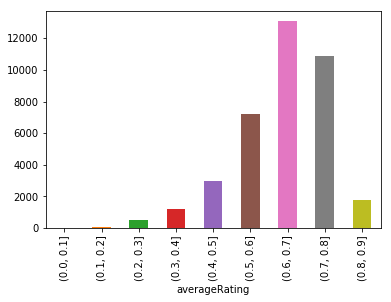

In [24]:
df_averageRating = ds_full[['averageRating']]
df_averageRating = pd.to_numeric(df_averageRating['averageRating'], errors='coerce')
df_averageRating.groupby(pd.cut(df_averageRating, np.arange(0,1,0.1))).count().plot.bar()
del df_averageRating

As you can see, the data is centered between 0.5 and 0.8 so we are going to create five tags for represent the averageRating, trying to let the output variable balanced 

In [25]:
ds_full = ds_full.sort_values(by='averageRating')
ds_full['tag'] = 0
ds = np.split(ds_full, 6)

ds[1]['tag'] = 1
ds[2]['tag'] = 2
ds[3]['tag'] = 3
ds[4]['tag'] = 4
ds[5]['tag'] = 5
ds_full = pd.concat(ds)

ds_full.sample(n=100)[['averageRating','tag']]

averageRating  tag
31714       0.525253    0
11654       0.777778    5
33331       0.232323    0
29115       0.525253    0
26512       0.404040    0
27146       0.686869    3
10239       0.464646    0
35504       0.696970    3
18148       0.585859    1
13213       0.676768    3
26702       0.666667    3
34445       0.646465    2
9578        0.606061    2
5768        0.727273    4
12731       0.606061    1
19426       0.545455    1
12327       0.616162    2
20332       0.656566    2
20691       0.626263    2
30875       0.656566    2
37004       0.767677    5
25988       0.616162    2
31557       0.666667    3
10148       0.565657    1
36418       0.585859    1
26174       0.434343    0
35765       0.535354    1
11671       0.646465    2
8163        0.616162    2
30119       0.707071    4
...              ...  ...
16637       0.555556    1
9541        0.787879    5
30761       0.717172    4
7302        0.666667    3
19255       0.696970    3
21499       0.737374    4
9395        0.575758    1
2878        0.525253    0
20361       0.676768    3
19407       0.717172    4
2373        0.707071    4
8263        0.505051    0
22666       0.797980    5
34091       0.282828    0
30709       0.717172    4
3948        0.666667    3
17006       0.656566    3
24899       0.787879    5
16156       0.616162    2
2597        0.707071    4
12183       0.464646    0
22963       0.525253    0
33145       0.525253    0
37757       0.656566    2
15          0.595960    1
18308       0.606061    1
32750       0.787879    5
5284        0.535354    1
5840        0.797980    5
6143        0.676768    3

[100 rows x 2 columns]

#### Now we put the same values into only one averageRating tag because after slicing, some averageRating values had different tags 

Here's an example

In [26]:
ds_full[ds_full['tag'] == 4][['averageRating', 'tag']].tail(3)
ds_full[ds_full['tag'] == 5][['averageRating', 'tag']].head(3)

averageRating  tag
3939        0.747475    4
18263       0.747475    4
18929       0.747475    4

averageRating  tag
5771        0.747475    5
29550       0.747475    5
3588        0.747475    5

In [27]:
for tag in range(6):
    if tag < 5:        
        last_value = ds_full[ds_full['tag'] == tag].iloc[-1].averageRating
        first_value = ds_full[ds_full['tag'] == tag + 1].iloc[0].averageRating
        if last_value == first_value:
            ds_full.loc[(ds_full['tag'] == tag) & (ds_full['averageRating'] == last_value), 'tag'] = tag + 1

for tag in range(6):
    df_max_values['min_tag_'+str(tag)] = ds_full[ds_full['tag'] == tag].iloc[0].averageRating
    df_max_values['max_tag_'+str(tag)] = ds_full[ds_full['tag'] == tag].iloc[-1].averageRating

df_max_values = pd.read_csv('df_max_values.csv')

max_averageRating  max_runtimeMinutes  min_tag_0  max_tag_0  min_tag_1  \
0                9.9               210.0    0.10101   0.525253   0.535354   

   max_tag_1  min_tag_2  max_tag_2  min_tag_3  max_tag_3  min_tag_4  \
0    0.59596   0.606061   0.646465   0.656566    0.69697   0.707071   

   max_tag_4  min_tag_5  max_tag_5  
0   0.737374   0.747475        1.0

Now we show what we've done

In [55]:
ds_full[ds_full['tag'] == 3][['averageRating', 'tag']].tail(3)
ds_full[ds_full['tag'] == 4][['averageRating', 'tag']].head(3)
ds_full = ds_full.drop(columns=['averageRating'])

averageRating  tag
6103         0.69697    3
6110         0.69697    3
36454        0.69697    3

averageRating  tag
11207       0.707071    4
14777       0.707071    4
561         0.707071    4

# NaN Values
### Now we have to deal with null values

#### Let's see the null values by column

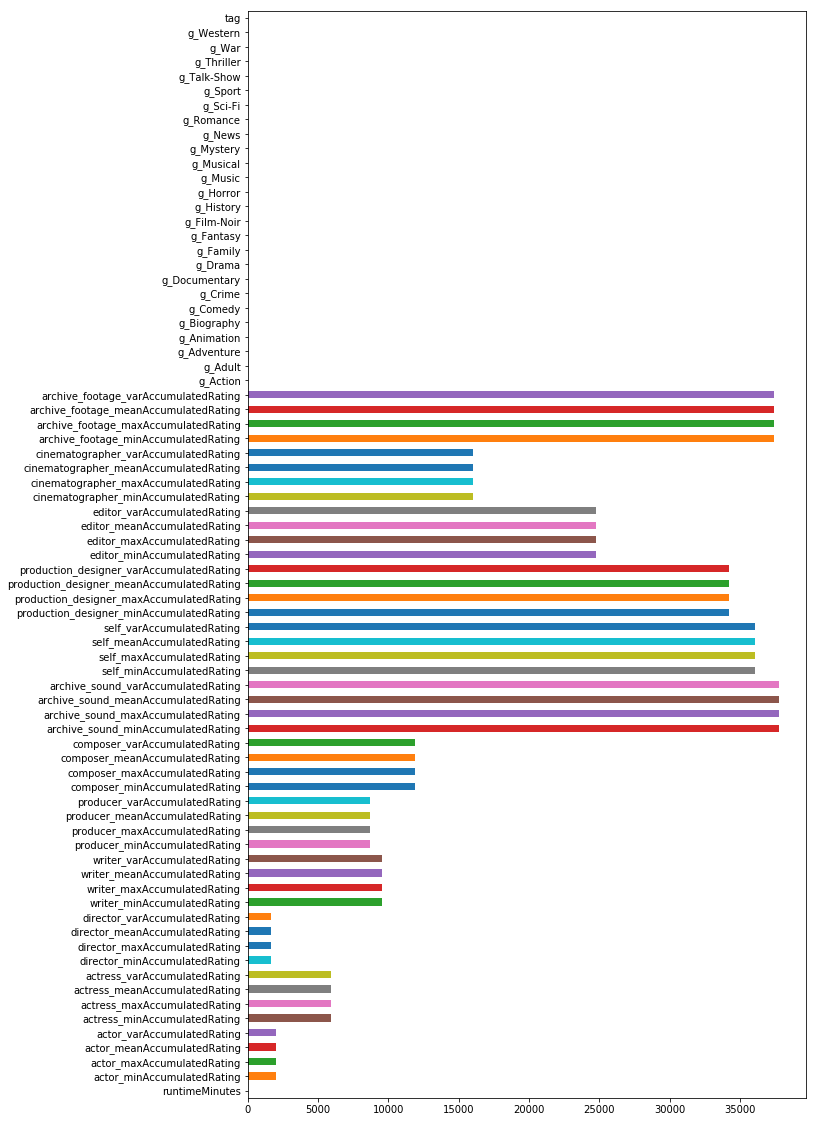

In [56]:
ds_full.isnull().sum().plot(kind = 'barh', figsize= [10,20])

### We've taken the decision of only consider the columns which has its null values below of the 40% of the data with not null values

In [57]:
for col in ds_full.columns:
    if ds_full.isnull().sum()[col] > ds_full[col].count() / 2.5:
        ds_full = ds_full.drop(columns=[col])

Now our dataset nulls values looks like

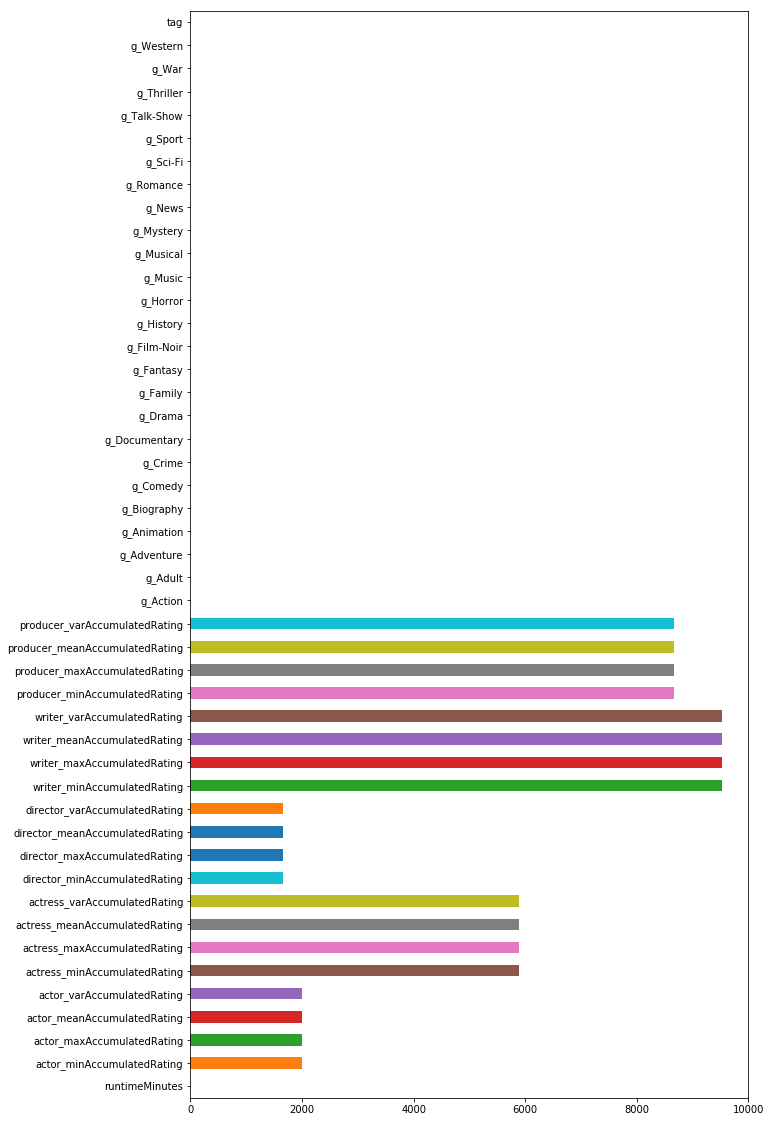

In [67]:
ds_full.isnull().sum().plot(kind = 'barh', figsize= [10,20])

And now we have less columns but all of them has at least 60% of data

In [59]:
ds_full.shape

(37818, 47)

And as expected, the columns that we've now are those which better describes the dataset (and a movie too)

So, for predicting we'll need info about the actors, the actresss, the directors, the writers, the producers and the genres involved on it.

### Filling NaN values

To do it we're going to set the value as the mean of the analyzed column 

In [68]:
def fill_na_with_mean():
    cols = []
    for col in ds_full.columns:
        if ds_full[col].isnull().sum() > 0:
            cols.append(col)

    for col in cols:
        mean = ds_full[col].notnull().mean()
        ds_full[col] = ds_full[col].fillna(mean)

In [181]:
fill_na_with_mean()

['actor_minAccumulatedRating', 'actor_maxAccumulatedRating', 'actor_meanAccumulatedRating', 'actor_varAccumulatedRating', 'actress_minAccumulatedRating', 'actress_maxAccumulatedRating', 'actress_meanAccumulatedRating', 'actress_varAccumulatedRating', 'director_minAccumulatedRating', 'director_maxAccumulatedRating', 'director_meanAccumulatedRating', 'director_varAccumulatedRating', 'writer_minAccumulatedRating', 'writer_maxAccumulatedRating', 'writer_meanAccumulatedRating', 'writer_varAccumulatedRating', 'producer_minAccumulatedRating', 'producer_maxAccumulatedRating', 'producer_meanAccumulatedRating', 'producer_varAccumulatedRating']


Here we tried to fill the NaN values with the average of the column depending on the genres that the film has.

In [174]:
ds = ds_full.copy()

def fill_na_with_mean_by_genre():
    cols = []
    f = []
    for col in ds.columns:
        if ds[col].isnull().sum() > 0:
            cols.append(col)

    df_genres = df_genres_ohe.reset_index('tconst').iloc[0:0].copy()
    df_genres = df_genres.drop(columns=['tconst'])

    iterables = [df_genres.columns, cols]

    idx = pd.MultiIndex.from_product(iterables=iterables, names=['genre', 'statistic'])

    serie = pd.Series(np.zeros(500), index=idx)

    df_fillna = pd.DataFrame(serie)
    df_fillna = df_fillna.reset_index()
    df_fillna = df_fillna[['genre', 'statistic']]

    # It gets the mean by genre for each rol and statisctic 
    for row in df_fillna.values:
        genre = row[0]
        statistic = row[1]
        mean = ds.loc[ds[genre] == 1][statistic].mean()
        df_fillna.loc[(df_fillna['genre'] == genre) &  (df_fillna['statistic'] == statistic), 'value'] = mean

    def get_genres(row):
        genres = []
        for idx, genre in enumerate(df_genres.columns):
            if row[idx+21] == 1:
                genres.append(genre)
        return genres

    def get_fillna_value_by_genres(col, genres):
        genres_mean_sum = 0
        if len(genres) > 0:
            for genre in genres:
                genres_mean_sum += df_fillna.loc[(df_fillna['genre'] == genre) &  (df_fillna['statistic'] == col)]['value']
            return genres_mean_sum / len(genres)
        return genres_mean_sum

    def fill_na(row, col):
        genres = get_genres(row)
        value = get_fillna_value_by_genres(col, genres)
        return value

    for col in cols:
        mask = ds[col].isnull()
        ds.loc[(mask), col] = ds[mask].apply(lambda x: fill_na(x, col))

# Graphs

## Genres

### From df_dummies we will make a graph to show the distribution of the movies according to their possibles genres. Remember that every movie can have more than one genre.

In [178]:
df_genres_ohe.reset_index().drop(columns=['tconst']).sum().plot(kind = 'bar', figsize= [15,10])

## Runtime Minutes

### Now we will analize the variable runtime minutes, capturing the data in a new data frame, removing duplicates and turning the runtime Minutes info to numeric.

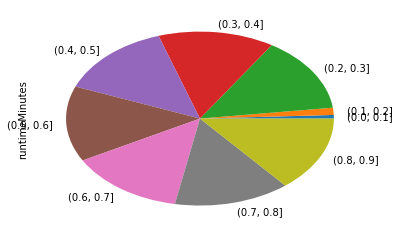

In [179]:
df_runtime = ds_full['runtimeMinutes']
df_runtime = df_runtime.drop_duplicates()
df_runtime.groupby(pd.cut(df_runtime, np.arange(0.0, 1.0, 0.1))).count().plot.pie()
del df_runtime

## Output Variable

### We tried to see how well balanced our data was , and as you can see in this graphic it isnt... we will have to give weight to certain errors in order to compensate this factor. We evaluated taking random samples from the biggest bag of ratings (5-6,6-7.7-8) but the problem with this is that we don't have many data, and we need to keep the most of it.

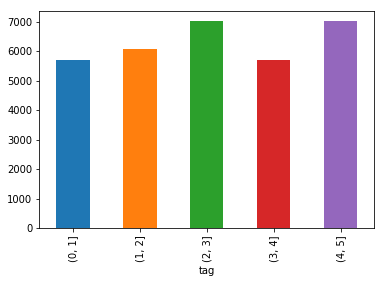

In [180]:
df_tag = ds_full[['tag']]
df_tag = pd.to_numeric(df_tag['tag'], errors='coerce')
df_tag.groupby(pd.cut(df_tag, np.arange(0,6,1))).count().plot.bar()
del df_tag